## Finding Relative Value Trades on the Treasury Yield Curve using PCA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline
sns.set_theme(style="whitegrid", palette="deep")

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pd.options.display.float_format = '{:.4f}'.format

## Getting & Cleaning Data

In [2]:
weblink = 'https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value='

In [3]:
yrs = range(2010, 2022+1)
rates = pd.DataFrame()

for i in yrs:
    link = weblink + str(i)
    webpage = pd.read_html(link)
    rates = rates.append(webpage[0])

In [4]:
rates.head()

Date  20 YR  30 YR  Extrapolation Factor  8 WEEKS BANK DISCOUNT  \
0  01/04/2010    nan    nan                   nan                    nan   
1  01/05/2010    nan    nan                   nan                    nan   
2  01/06/2010    nan    nan                   nan                    nan   
3  01/07/2010    nan    nan                   nan                    nan   
4  01/08/2010    nan    nan                   nan                    nan   

   COUPON EQUIVALENT  52 WEEKS BANK DISCOUNT  COUPON EQUIVALENT.1   1 Mo  \
0                nan                     nan                  nan 0.0500   
1                nan                     nan                  nan 0.0300   
2                nan                     nan                  nan 0.0300   
3                nan                     nan                  nan 0.0200   
4                nan                     nan                  nan 0.0200   

   2 Mo   3 Mo   6 Mo   1 Yr   2 Yr   3 Yr   5 Yr   7 Yr  10 Yr  20 Yr  30 Yr  
0   nan 0.0800 0.1800 0.4500 1.0900 1.6600 2.6500 3.3600 3.8500 4.6000 4.6500  
1   nan 0.0700 0.1700 0.4100 1.0100 1.5700 2.5600 3.2800 3.7700 4.5400 4.5900  
2   nan 0.0600 0.1500 0.4000 1.0100 1.6000 2.6000 3.3300 3.8500 4.6300 4.7000  
3   nan 0.0500 0.1600 0.4000 1.0300 1.6200 2.6200 3.3300 3.8500 4.6200 4.6900  
4   nan 0.0500 0.1500 0.3700 0.9600 1.5600 2.5700 3.3100 3.8300 4.6100 4.7000

In [5]:
rates = rates[['Date', '1 Mo', '3 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr', '7 Yr', '10 Yr', '20 Yr', '30 Yr']]
rates['Date'] = pd.to_datetime(rates['Date'])
rates = rates.set_index('Date')
rates.columns = ['1mo', '3mo', '6mo', '1yr', '2yr', '3yr', '5yr', '7yr', '10yr', '20yr', '30yr']

rates.head()

1mo    3mo    6mo    1yr    2yr    3yr    5yr    7yr   10yr  \
Date                                                                        
2010-01-04 0.0500 0.0800 0.1800 0.4500 1.0900 1.6600 2.6500 3.3600 3.8500   
2010-01-05 0.0300 0.0700 0.1700 0.4100 1.0100 1.5700 2.5600 3.2800 3.7700   
2010-01-06 0.0300 0.0600 0.1500 0.4000 1.0100 1.6000 2.6000 3.3300 3.8500   
2010-01-07 0.0200 0.0500 0.1600 0.4000 1.0300 1.6200 2.6200 3.3300 3.8500   
2010-01-08 0.0200 0.0500 0.1500 0.3700 0.9600 1.5600 2.5700 3.3100 3.8300   

             20yr   30yr  
Date                      
2010-01-04 4.6000 4.6500  
2010-01-05 4.5400 4.5900  
2010-01-06 4.6300 4.7000  
2010-01-07 4.6200 4.6900  
2010-01-08 4.6100 4.7000

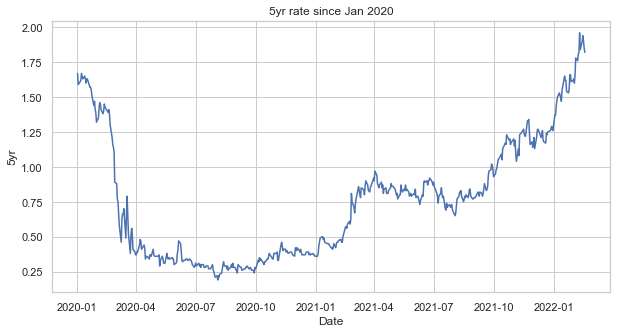

In [6]:
plt.figure(figsize=(10,5))

sns.lineplot(x=rates.query("Date>='1 Jan 2020'").index, y=rates.query("Date>='1 Jan 2020'")['5yr']).\
set_title('5yr rate since Jan 2020');

In [7]:
n_term_point = rates.shape[1]
n_term_point

11

In [8]:
pd.DataFrame({'mean':rates.mean(), 'std':rates.std()}).T

1mo    3mo    6mo    1yr    2yr    3yr    5yr    7yr   10yr   20yr  \
mean 0.4771 0.5100 0.5781 0.6598 0.8580 1.0638 1.4922 1.8634 2.1940 2.7063   
std  0.7375 0.7528 0.7686 0.7732 0.7351 0.7009 0.6624 0.6661 0.7010 0.7648   

       30yr  
mean 2.9490  
std  0.7770

In [9]:
rates.isna().sum()

1mo     1
3mo     1
6mo     1
1yr     1
2yr     1
3yr     1
5yr     1
7yr     1
10yr    1
20yr    1
30yr    1
dtype: int64

In [10]:
print('before removing missing values: ', rates.shape)
rates = rates.dropna()
print('after removing missing values: ', rates.shape)

before removing missing values:  (3038, 11)
after removing missing values:  (3037, 11)


## PCA Modeling

### Scaling data

In [11]:
sc = StandardScaler()
rates_sc = sc.fit_transform(rates)
rates_sc = pd.DataFrame(rates_sc, columns=rates.columns, index=rates.index)
rates_sc.head()

1mo     3mo     6mo     1yr    2yr    3yr    5yr    7yr   10yr  \
Date                                                                            
2010-01-04 -0.5792 -0.5713 -0.5180 -0.2714 0.3157 0.8508 1.7481 2.2471 2.3629   
2010-01-05 -0.6063 -0.5846 -0.5310 -0.3232 0.2068 0.7224 1.6122 2.1269 2.2488   
2010-01-06 -0.6063 -0.5979 -0.5570 -0.3361 0.2068 0.7652 1.6726 2.2020 2.3629   
2010-01-07 -0.6199 -0.6112 -0.5440 -0.3361 0.2340 0.7937 1.7028 2.2020 2.3629   
2010-01-08 -0.6199 -0.6112 -0.5570 -0.3749 0.1388 0.7081 1.6273 2.1720 2.3344   

             20yr   30yr  
Date                      
2010-01-04 2.4764 2.1894  
2010-01-05 2.3979 2.1122  
2010-01-06 2.5156 2.2538  
2010-01-07 2.5025 2.2409  
2010-01-08 2.4895 2.2538

In [12]:
# Scaled data with Mean=0 and Std=1
pd.DataFrame({'mean':rates_sc.mean(), 'std':rates_sc.std()}).T

1mo     3mo     6mo     1yr    2yr    3yr    5yr     7yr    10yr  \
mean 0.0000 -0.0000 -0.0000 -0.0000 0.0000 0.0000 0.0000 -0.0000 -0.0000   
std  1.0002  1.0002  1.0002  1.0002 1.0002 1.0002 1.0002  1.0002  1.0002   

       20yr   30yr  
mean 0.0000 0.0000  
std  1.0002 1.0002

### Running PCA - 
* **3 principal components capture most of the information**
* These 3 PCs are popularly interpreted as (1) Level, (2) Slope and (3) Curvature of the yield curve, considering their loadings

In [13]:
pca_model = PCA()
pca_model.fit(rates_sc)

pc_names = ['PC'+str(i) for i in range(1,n_term_point+1)]

In [14]:
pct_exp = pd.Series(pca_model.explained_variance_ratio_*100, index=pc_names)
pct_exp

PC1    65.0647
PC2    32.1134
PC3     2.4329
PC4     0.2710
PC5     0.0511
PC6     0.0369
PC7     0.0122
PC8     0.0079
PC9     0.0041
PC10    0.0036
PC11    0.0023
dtype: float64

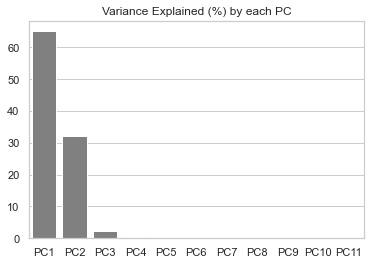

In [15]:
sns.barplot(x=pct_exp.index, y=pct_exp.values, color='grey').\
set_title('Variance Explained (%) by each PC');

In [16]:
loadings = pd.DataFrame(pca_model.components_.T.round(4))
loadings.index = rates.columns
loadings.columns = pc_names
loadings

PC1     PC2     PC3     PC4     PC5     PC6     PC7     PC8     PC9  \
1mo  0.3197 -0.2504 -0.3836 -0.4727 -0.2162  0.4034  0.4130  0.2378 -0.1473   
3mo  0.3250 -0.2463 -0.3222 -0.2314  0.0562 -0.0857 -0.4134 -0.3577  0.4144   
6mo  0.3310 -0.2387 -0.2221  0.0866  0.0403 -0.3725 -0.2940 -0.0702 -0.2130   
1yr  0.3398 -0.2170 -0.0797  0.3992  0.1655 -0.3849  0.2630  0.3069 -0.2760   
2yr  0.3574 -0.1407  0.1834  0.4582  0.0974  0.2744  0.2331  0.0255  0.4471   
3yr  0.3648 -0.0462  0.3766  0.1673 -0.1002  0.4644 -0.1801 -0.2667 -0.1440   
5yr  0.3458  0.1625  0.4252 -0.2601 -0.1663 -0.0491 -0.3093  0.1644 -0.4028   
7yr  0.3010  0.3040  0.2813 -0.3282 -0.0196 -0.3380  0.1155  0.3359  0.5123   
10yr 0.2383  0.4094 -0.0349 -0.1006  0.1290 -0.1888  0.4873 -0.6616 -0.1710   
20yr 0.1519  0.4776 -0.3113  0.0225  0.6544  0.3156 -0.2333  0.2479 -0.0821   
30yr 0.1279  0.4858 -0.3997  0.3636 -0.6547  0.0098 -0.1234  0.0743  0.0610   

        PC10    PC11  
1mo  -0.0781  0.0128  
3mo   0.4400 -0.0401  
6mo  -0.6932  0.1373  
1yr   0.4129 -0.2936  
2yr  -0.0609  0.5154  
3yr  -0.1308 -0.5725  
5yr   0.2859  0.4570  
7yr  -0.2092 -0.2883  
10yr  0.0104  0.0864  
20yr -0.0247 -0.0143  
30yr  0.0473 -0.0138

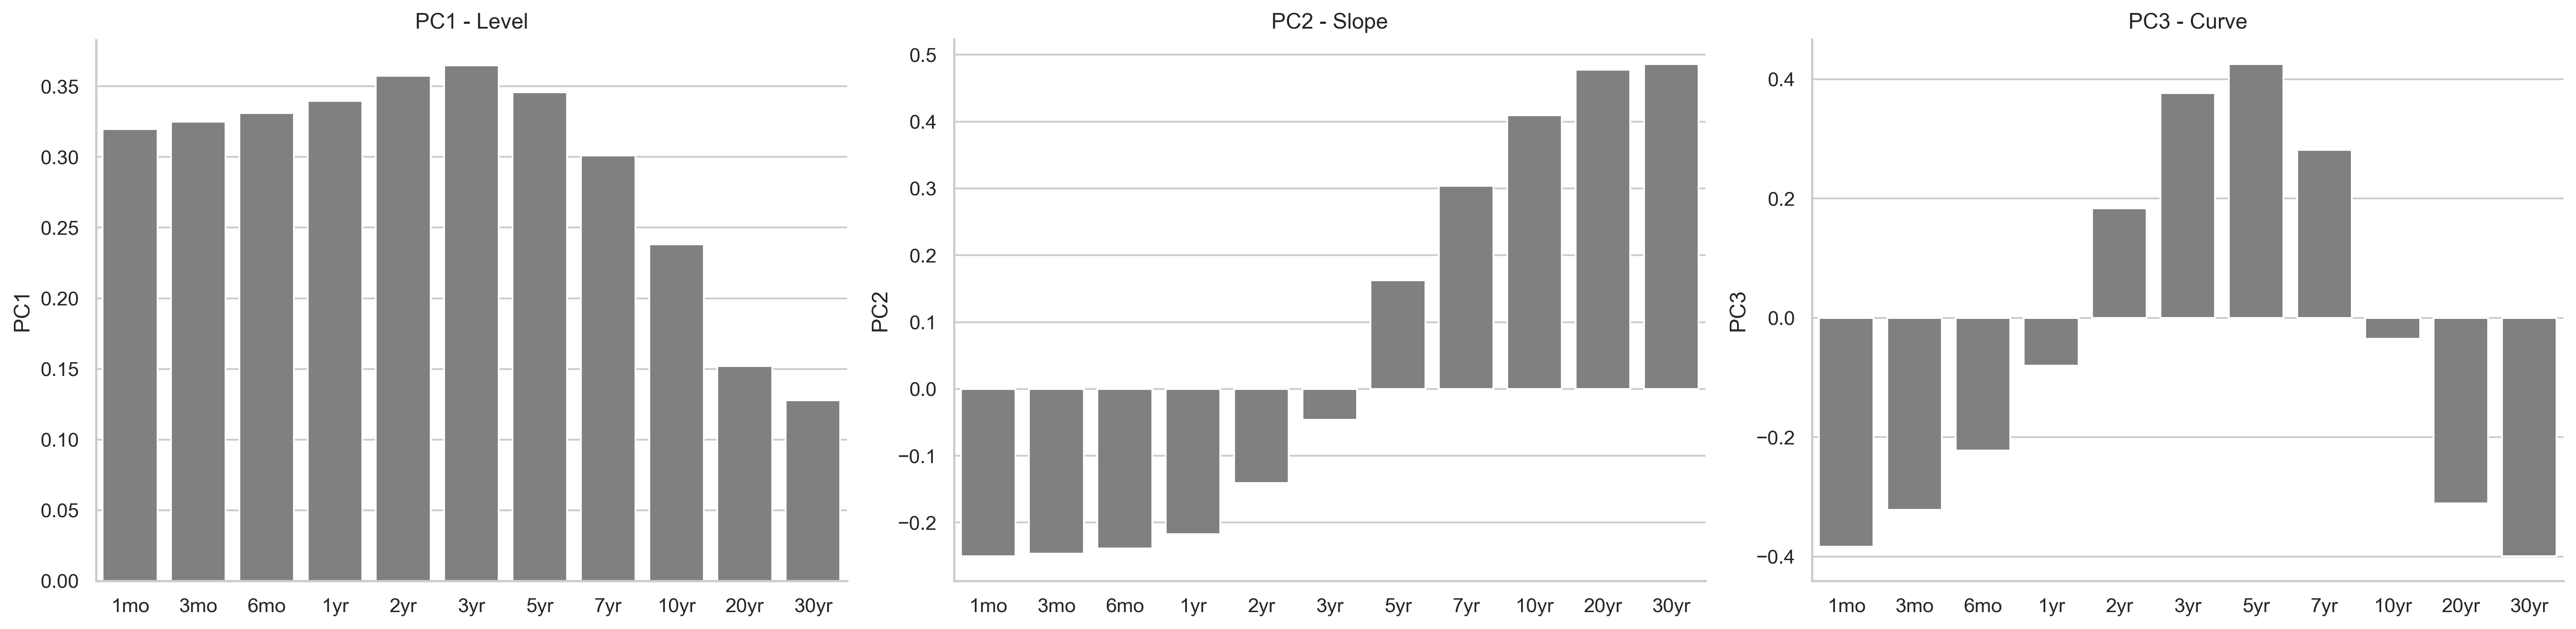

In [17]:
plt.figure(figsize=(20,5), dpi=300)
plt.subplot(1,3,1)
sns.barplot(x=loadings.index, y=loadings['PC1'], color='grey', label='PC1').set_title('PC1 - Level');
plt.subplot(1,3,2)
sns.barplot(x=loadings.index, y=loadings['PC2'], color='grey', label='PC2').set_title('PC2 - Slope');
plt.subplot(1,3,3)
sns.barplot(x=loadings.index, y=loadings['PC3'], color='grey', label='PC3').set_title('PC3 - Curve');
plt.tight_layout()
sns.despine()

## Reconstructing Data using fewer PCAs

In [18]:
# Number of PCs to be used
nPC = 3

In [19]:
# Calculating PCA Scores
scores = np.matmul(rates_sc, loadings)
scores.columns = loadings.columns

print(scores.shape)
scores.head()

(3037, 11)


PC1    PC2    PC3     PC4    PC5    PC6     PC7    PC8    PC9  \
Date                                                                          
2010-01-04 2.2888 4.5655 0.5682 -0.0383 0.1300 0.1060  0.0206 0.0562 0.0256   
2010-01-05 2.0360 4.4308 0.4892 -0.0592 0.1378 0.0747  0.0032 0.0587 0.0254   
2010-01-06 2.1410 4.6455 0.4660 -0.0541 0.1171 0.0991  0.0060 0.0492 0.0165   
2010-01-07 2.1636 4.6363 0.5104 -0.0390 0.1144 0.1049 -0.0015 0.0437 0.0064   
2010-01-08 2.0385 4.6321 0.4261 -0.0769 0.0992 0.0740 -0.0072 0.0472 0.0114   

              PC10    PC11  
Date                        
2010-01-04  0.0070 -0.0107  
2010-01-05 -0.0023 -0.0149  
2010-01-06  0.0055 -0.0264  
2010-01-07 -0.0053 -0.0124  
2010-01-08 -0.0100 -0.0312

In [20]:
# Separating scores for top PCs
scores_pc = scores.loc[:, scores.columns[0:nPC]]

print(scores_pc.shape)
scores_pc.head()

(3037, 3)


PC1    PC2    PC3
Date                           
2010-01-04 2.2888 4.5655 0.5682
2010-01-05 2.0360 4.4308 0.4892
2010-01-06 2.1410 4.6455 0.4660
2010-01-07 2.1636 4.6363 0.5104
2010-01-08 2.0385 4.6321 0.4261

In [21]:
# Inverse of Loadings - separated for top PCs
loadings_inv = np.linalg.inv(loadings)

loadings_inv_pc= pd.DataFrame(loadings_inv[0:nPC])
loadings_inv_pc.index   = scores_pc.columns
loadings_inv_pc.columns = loadings.index

print(loadings_inv_pc.shape)
loadings_inv_pc.head()

(3, 11)


1mo     3mo     6mo     1yr     2yr     3yr    5yr    7yr    10yr  \
PC1  0.3196  0.3250  0.3310  0.3397  0.3573  0.3648 0.3458 0.3009  0.2383   
PC2 -0.2504 -0.2463 -0.2388 -0.2170 -0.1407 -0.0462 0.1626 0.3041  0.4094   
PC3 -0.3835 -0.3222 -0.2222 -0.0797  0.1834  0.3766 0.4253 0.2813 -0.0349   

       20yr    30yr  
PC1  0.1519  0.1279  
PC2  0.4777  0.4859  
PC3 -0.3114 -0.3997

In [22]:
# Reconstructing 'scaled' data
# Matrix multiplication with Pandas Dataframes throws error even when dimensions are proper
rates_pca_sc = pd.DataFrame(np.matmul(scores_pc.to_numpy(), loadings_inv_pc.to_numpy()), 
                            columns=loadings_inv_pc.columns, index=scores_pc.index)

print(rates_pca_sc.shape)
rates_pca_sc.head()

(3037, 11)


1mo     3mo     6mo     1yr    2yr    3yr    5yr    7yr   10yr  \
Date                                                                            
2010-01-04 -0.6294 -0.5639 -0.4586 -0.2585 0.2797 0.8382 1.7753 2.2368 2.3947   
2010-01-05 -0.6462 -0.5874 -0.4926 -0.3089 0.1939 0.7225 1.6324 2.0976 2.2821   
2010-01-06 -0.6575 -0.5987 -0.5040 -0.3179 0.1969 0.7421 1.6938 2.1879 2.3958   
2010-01-07 -0.6650 -0.6034 -0.5041 -0.3118 0.2144 0.7675 1.7190 2.2044 2.3959   
2010-01-08 -0.6716 -0.6159 -0.5258 -0.3466 0.1549 0.6903 1.6392 2.1418 2.3673   

             20yr   30yr  
Date                      
2010-01-04 2.3517 2.2838  
2010-01-05 2.2735 2.2175  
2010-01-06 2.3992 2.3445  
2010-01-07 2.3845 2.3252  
2010-01-08 2.3897 2.3409

In [23]:
# Descaling data
rates_pca = pd.DataFrame(sc.inverse_transform(rates_pca_sc),
                         columns=rates_pca_sc.columns, index=rates_pca_sc.index)

print(rates_pca.shape)
rates_pca.head()

(3037, 11)


1mo    3mo    6mo    1yr    2yr    3yr    5yr    7yr   10yr  \
Date                                                                         
2010-01-04  0.0130 0.0856 0.2256 0.4600 1.0636 1.6512 2.6680 3.3532 3.8723   
2010-01-05  0.0006 0.0679 0.1995 0.4211 1.0005 1.5701 2.5734 3.2605 3.7933   
2010-01-06 -0.0077 0.0594 0.1908 0.4141 1.0028 1.5838 2.6140 3.3206 3.8730   
2010-01-07 -0.0133 0.0558 0.1906 0.4188 1.0156 1.6016 2.6307 3.3316 3.8731   
2010-01-08 -0.0181 0.0465 0.1740 0.3919 0.9718 1.5475 2.5778 3.2899 3.8531   

             20yr   30yr  
Date                      
2010-01-04 4.5047 4.7233  
2010-01-05 4.4449 4.6719  
2010-01-06 4.5410 4.7705  
2010-01-07 4.5297 4.7555  
2010-01-08 4.5338 4.7677

## Relative Value assessment

In [24]:
# Term point of interest
term = '10yr'

In [25]:
relative_value = pd.DataFrame(pd.concat([rates[term], rates_pca[term], rates[term]-rates_pca[term]], axis=1))
relative_value.columns = ['Actual', 'PCA', 'Diff']
relative_value['Cheap'] = (relative_value['Diff'] > 0)
relative_value.head()

Actual    PCA    Diff  Cheap
Date                                    
2010-01-04  3.8500 3.8723 -0.0223  False
2010-01-05  3.7700 3.7933 -0.0233  False
2010-01-06  3.8500 3.8730 -0.0230  False
2010-01-07  3.8500 3.8731 -0.0231  False
2010-01-08  3.8300 3.8531 -0.0231  False

In [26]:
relative_value['Cheap'].value_counts()

False    1581
True     1456
Name: Cheap, dtype: int64

### Long Term Trend
* any particular term point on the yield curve goes through cycles of 'richness'/'cheapness'

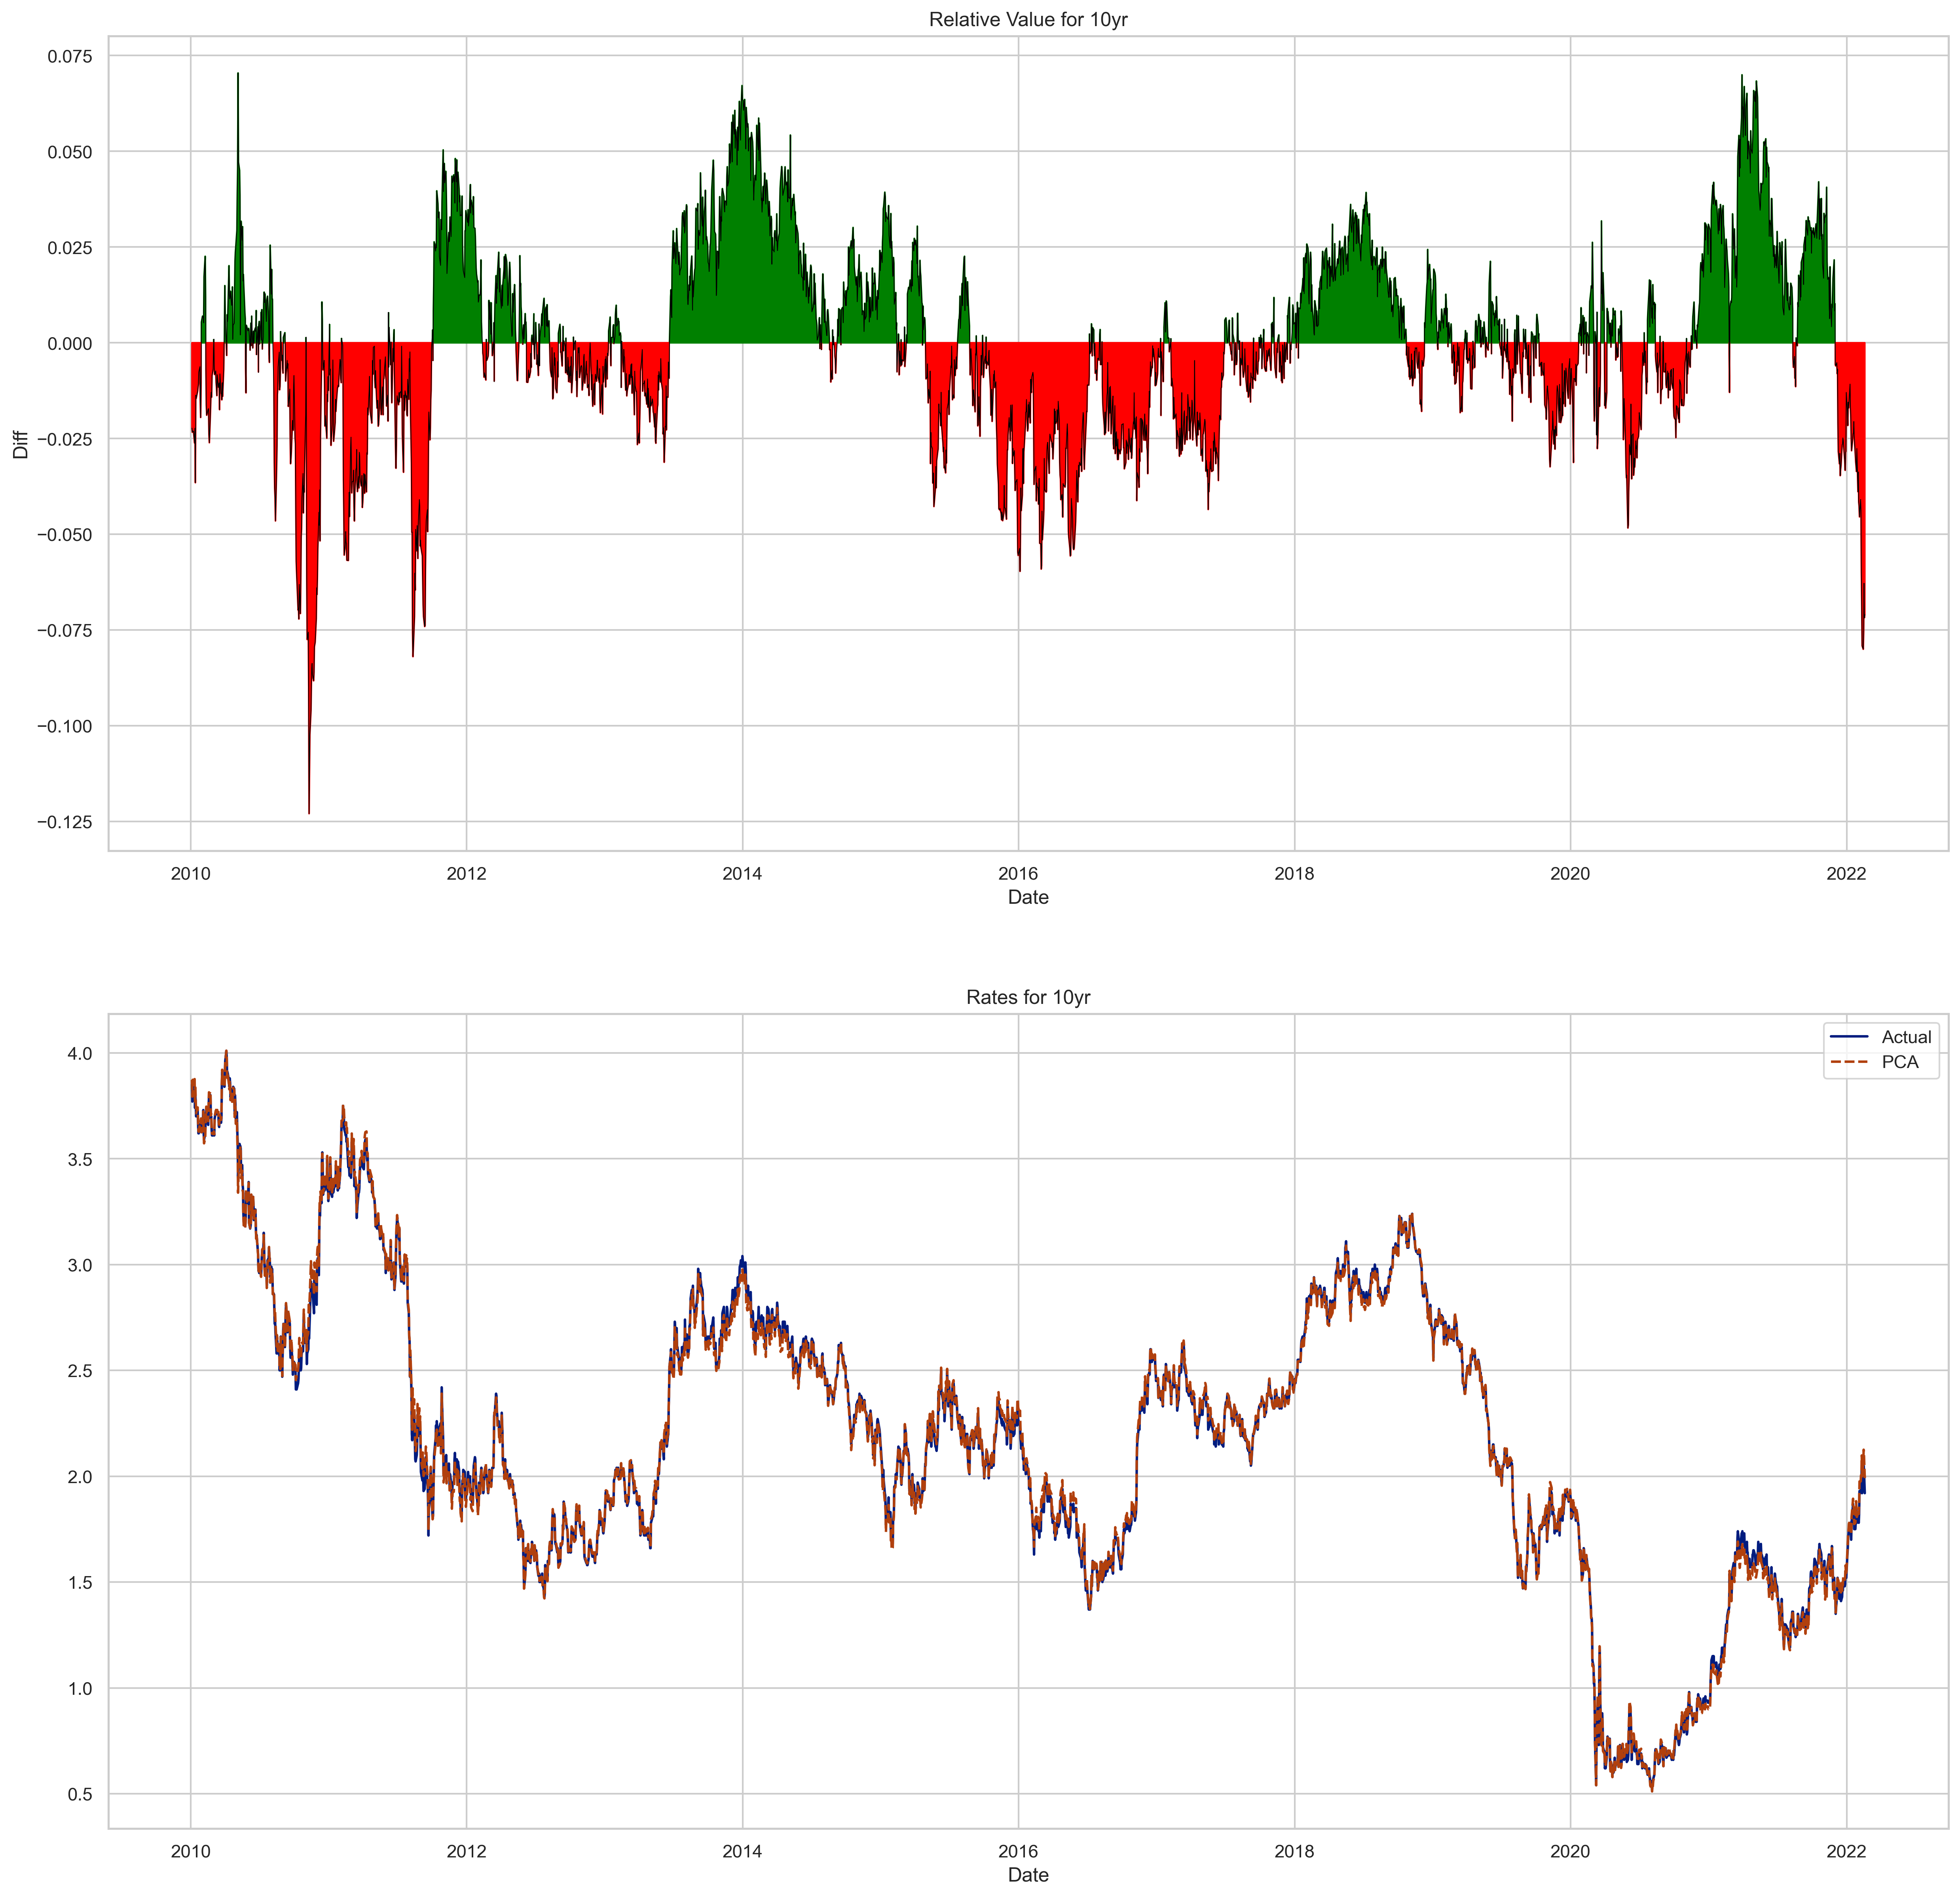

In [27]:
# Plotting Long Term Trend
plt.figure(figsize=(20,20), dpi=300)

plt.subplot(2,1,1)
sns.lineplot(data=relative_value['Diff'], color='black', linewidth=.5).set_title('Relative Value for {}'.format(term));
plt.fill_between(relative_value.index, 0, relative_value['Diff'], where=relative_value['Cheap'], color='green')
plt.fill_between(relative_value.index, 0, relative_value['Diff'], where=(~relative_value['Cheap']), color='red')

plt.subplot(2,1,2)
sns.lineplot(data=relative_value[['Actual', 'PCA']], palette='dark').set_title('Rates for {}'.format(term));


### Last 3 month Trend - for a particular term point

In [28]:
px.bar(data_frame=relative_value[-60:], y='Diff', color='Cheap', template='plotly_dark',
       color_discrete_sequence=["green", "red"], 
       width = 800, height=400,
       title='Relative Value for {} in last three months'.format(term))

In [29]:
px.line(data_frame=relative_value[-60:], y=['Actual', 'PCA'], template='plotly_dark',
        width = 800, height=400,
        title='Rates for {} in last three months'.format(term))

### Relative Value across the Yield Curve

In [30]:
last_week = rates[-5:] - rates_pca[-5:]
last_week = last_week.stack().reset_index()
last_week.columns =['Date', 'Term', 'RelativeValue']
last_week = last_week.set_index('Date')
last_week['Cheap'] = (last_week['RelativeValue'] >0)
# last_week.head()

In [33]:
px.bar(data_frame=last_week, y='RelativeValue', template='plotly_dark', color='Cheap',
       facet_col='Term', facet_col_wrap=4, 
       color_discrete_sequence={False: 'red', True: 'green'},
       title = 'Relative value across yield curve in past week',
       width = 800, height=600)